In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Functions
def convert_to_unix_time(dt_series):
    dt_series = pd.to_datetime(dt_series, format='%Y-%m-%d %H:%M:%S%z')
    return (dt_series - pd.Timestamp("1970-01-01", tz='UTC')) // pd.Timedelta('1s')

def prepare_data(df, n_steps):
    X, y = [], []
    for i in range(len(df) - n_steps):
        seq_x = df[i:(i + n_steps), :-1]
        seq_y = df[i + n_steps, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Load the training dataset
df_train_speed = pd.read_csv("Train_data.csv")

# Preprocess training data
df_train_speed['Timestamp'] = convert_to_unix_time(df_train_speed['Timestamp'])
scaler = MinMaxScaler()
df_train_scaled = scaler.fit_transform(df_train_speed[['Timestamp', 'Longitude', 'Latitude', 'Speed (km/h)']])
n_steps = 5
X, y = prepare_data(df_train_scaled, n_steps)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = Sequential()
model.add(LSTM(units=100, activation='tanh', input_shape=(n_steps, 3)))
model.add(Dense(units=1))
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Load the test dataset
df_test_speed = pd.read_csv("Test_data.csv")

# Preprocess test data
df_test_speed['Timestamp'] = convert_to_unix_time(df_test_speed['Timestamp'])
df_test_scaled = scaler.transform(df_test_speed[['Timestamp', 'Longitude', 'Latitude', 'Speed (km/h)']])
X_test, y_test = prepare_data(df_test_scaled, n_steps)

# Evaluate the model on test data
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Test RMSE: {rmse}') 
r2 = r2_score(y_test, y_pred)
print(f'Test R2 Score: {r2}')
model.save('RNN.h5')





Epoch 1/10

30205/30205 [==============================] - 112s 4ms/step - loss: 0.0229 - val_loss: 0.0214
Epoch 2/10
30205/30205 [==============================] - 100s 3ms/step - loss: 0.0210 - val_loss: 0.0211
Epoch 3/10
30205/30205 [==============================] - 104s 3ms/step - loss: 0.0203 - val_loss: 0.0199
Epoch 4/10
30205/30205 [==============================] - 95s 3ms/step - loss: 0.0199 - val_loss: 0.0200
Epoch 5/10
30205/30205 [==============================] - 107s 4ms/step - loss: 0.0196 - val_loss: 0.0192
Epoch 6/10
30205/30205 [==============================] - 114s 4ms/step - loss: 0.0193 - val_loss: 0.0191
Epoch 7/10
30205/30205 [==============================] - 115s 4ms/step - loss: 0.0191 - val_loss: 0.0191
Epoch 8/10
30205/30205 [==============================] - 125s 4ms/step - loss: 0.0190 - val_loss: 0.0188
Epoch 9/10
30205/30205 [==============================] - 114s 4ms/step - loss: 0.0188 - val_loss: 0.0189
Epoch 10/10
3330/3330 [=====================

c:\Users\ysrmhmt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


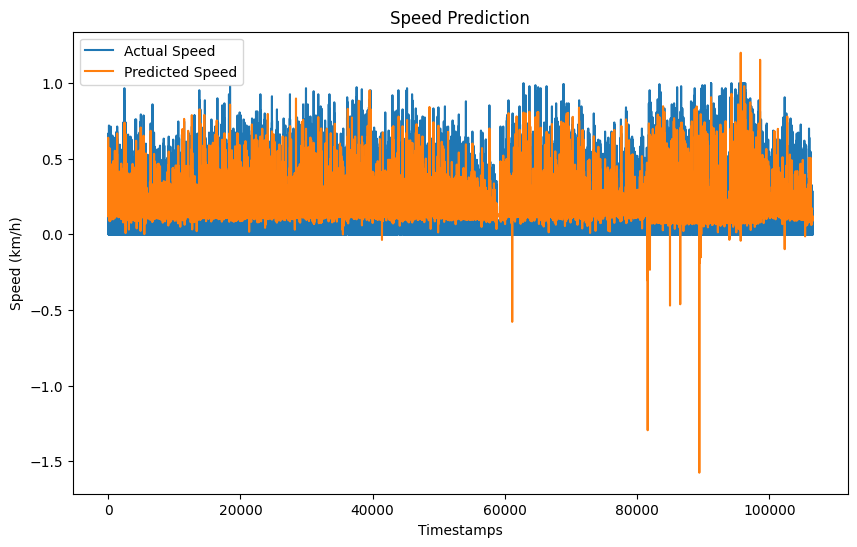

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Speed')
plt.plot(y_pred, label='Predicted Speed')
plt.title('Speed Prediction')
plt.xlabel('Timestamps')
plt.ylabel('Speed (km/h)')
plt.legend()
plt.show()


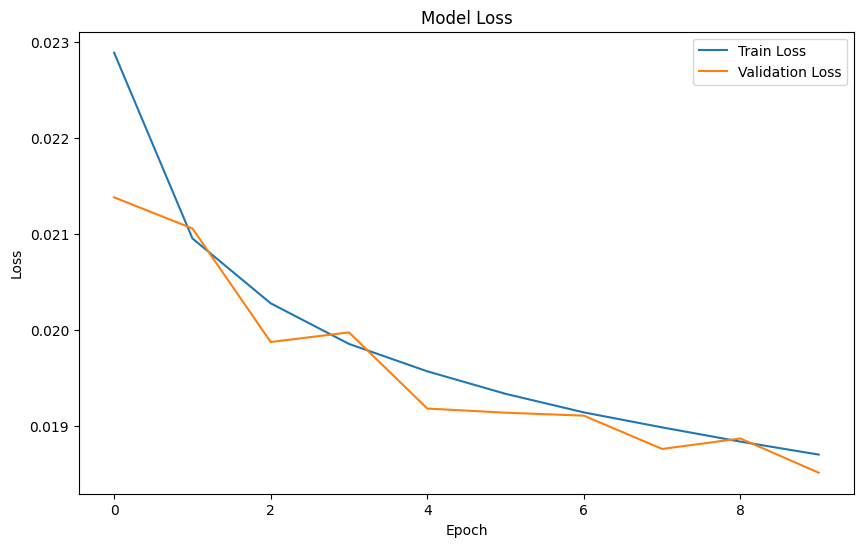

In [3]:
# Now you can plot the training and validation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model('speed_prediction_model.keras')

In [ ]:
df_test_speed = pd.read_csv("Jan_no_outlier.csv")
df_train = df_test_speed[(df_test_speed["Longitude"] >= 28.82545) & (df_test_speed["Longitude"] <= 29.12508) & 
                    (df_test_speed["Latitude"] <= 40.29373) & (df_test_speed["Latitude"] >= 40.16594)]

# Remove outliers from 'Speed (km/h)'
Q1 = df_test_speed['Speed (km/h)'].quantile(0)
Q3 = df_test_speed['Speed (km/h)'].quantile(1)
IQR = Q3 - Q1
filter = (df_test_speed['Speed (km/h)'] >= Q1 - 1.5 * IQR) & (df_test_speed['Speed (km/h)'] <= Q3 + 1.5 * IQR)
df_test_speed = df_test_speed.loc[filter]

# Convert timestamp to Unix time
df_test_speed['Timestamp'] = convert_to_unix_time(df_test_speed['Timestamp'])

# Normalize the dataset
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_test_speed[['Timestamp', 'Longitude', 'Latitude', 'Speed (km/h)']])

# Define the number of previous time steps to use for prediction
n_steps = 5

# Prepare the data
X_test, y_test = prepare_data(df_scaled, n_steps)
# Make predictions
y_pred = loaded_model.predict(X_test)

# Evaluate the model using RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Test RMSE: {rmse}')

# Evaluate the model using R2 score
r2 = r2_score(y_test, y_pred)
print(f'Test R2 Score: {r2}')


3320/3320 [==============================] - 6s 2ms/step
Test RMSE: 0.09498720317666456
Test R2 Score: 0.7226883619245186
